In [22]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from evaluate import evaluate_holdout

In [23]:
# Загрузка предобработанных данных
root = "../.."
input_path = f"{root}/data/processed"

scaled_droplet_size_data = pd.read_csv(f"{input_path}/scaled/droplet_size.csv")
encoded_droplet_size_data  = pd.read_csv(f"{input_path}/encoded/droplet_size.csv")
catboost_droplet_size_data = pd.read_csv(f"{input_path}/catboost/droplet_size.csv")

In [24]:
# Разделение признаков и целевой переменной
X_scaled = scaled_droplet_size_data.drop(columns=["experiment.results.droplet_size.value"])
y_scaled = scaled_droplet_size_data["experiment.results.droplet_size.value"]

X_encoded  = encoded_droplet_size_data .drop(columns=["experiment.results.droplet_size.value"])
y_encoded  = encoded_droplet_size_data ["experiment.results.droplet_size.value"]

X_catboost = catboost_droplet_size_data.drop(columns=["experiment.results.droplet_size.value"])
y_catboost = catboost_droplet_size_data["experiment.results.droplet_size.value"]

# Выделение категориальных признаков для CatBoost
catboost_features = X_catboost.select_dtypes(include=["object", "category"]).columns.tolist()
X_catboost[catboost_features] = X_catboost[catboost_features].fillna('nan')

results = {}

In [25]:
# Разделение данных на тренеровочную и тестовую выборки
TEST_SIZE = 0.2

X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(
    X_scaled, y_scaled, test_size = TEST_SIZE, random_state = 0 
)

X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test = train_test_split(
    X_encoded, y_encoded, test_size = TEST_SIZE, random_state = 0 
)

X_catboost_train, X_catboost_test, y_catboost_train, y_catboost_test = train_test_split(
    X_catboost, y_catboost, test_size = TEST_SIZE, random_state = 0 
)

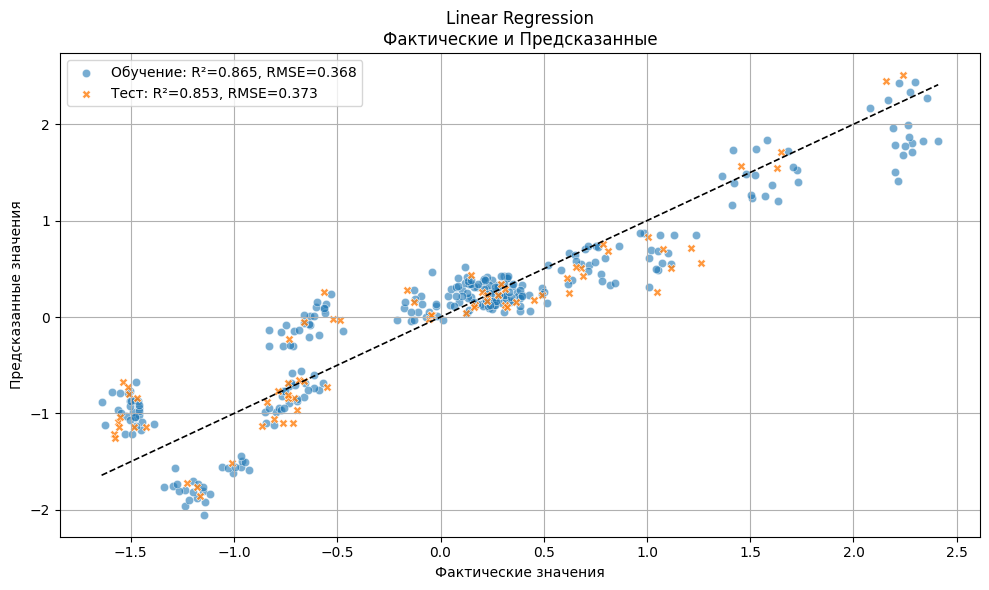

In [26]:
results["LinearRegression"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test, 
    LinearRegression(), "Linear Regression"
)

In [27]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-2, 3, 6),        # 0.01, 0.1, 1, 10, 100, 1000
    'epsilon': np.logspace(-3, -1, 3), # 0.001, 0.01, 0.1
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=3)
grid_search.fit(X_scaled_train, y_scaled_train)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'C': np.float64(10.0), 'epsilon': np.float64(0.01), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.9800747517013816


In [28]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(0, 2, 40),        
    'epsilon': np.logspace(-3, -1, 40),
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled_train, y_scaled_train)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits
Best parameters: {'C': np.float64(17.012542798525892), 'epsilon': np.float64(0.03888155180308087), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.9802733006478658


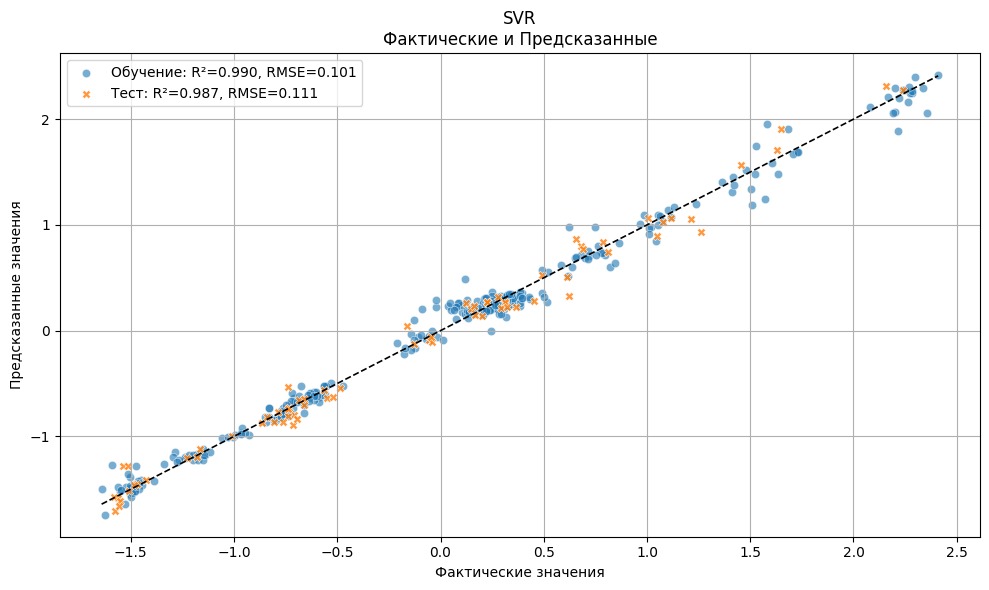

In [29]:
results["SVR"] = evaluate_holdout(
    X_scaled_train, X_scaled_test, 
    y_scaled_train, y_scaled_test,
    SVR(**grid_search.best_params_), "SVR"
)

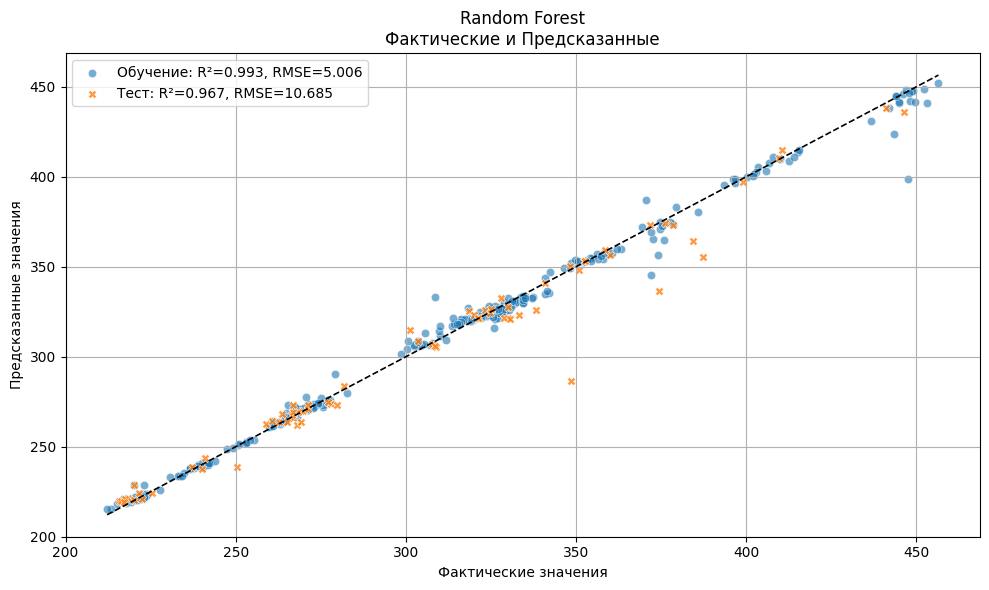

In [30]:
results["RandomForest"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    RandomForestRegressor(), "Random Forest"
)

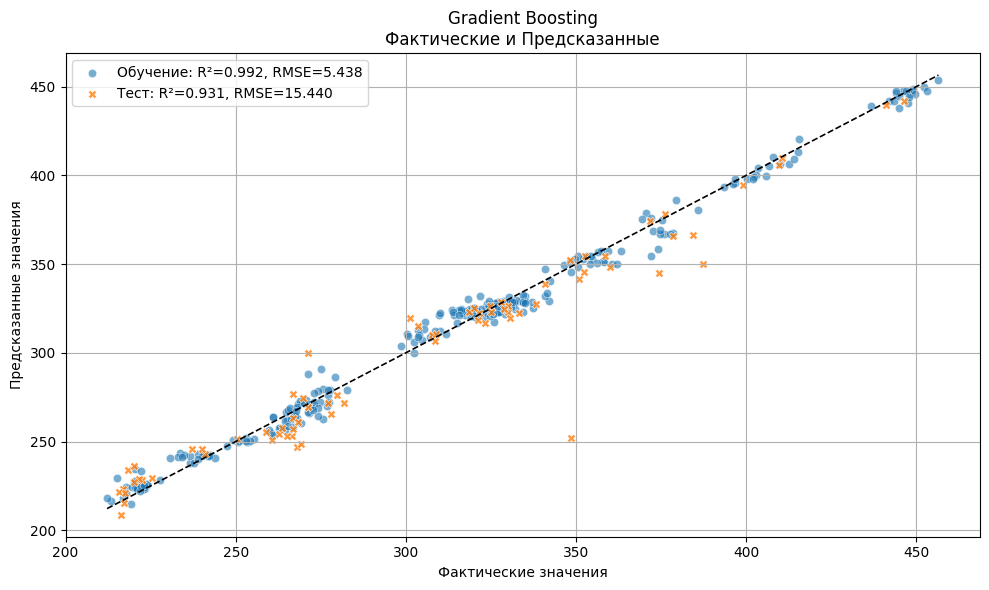

In [31]:
results["GradientBoosting"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    GradientBoostingRegressor(), "Gradient Boosting"
)

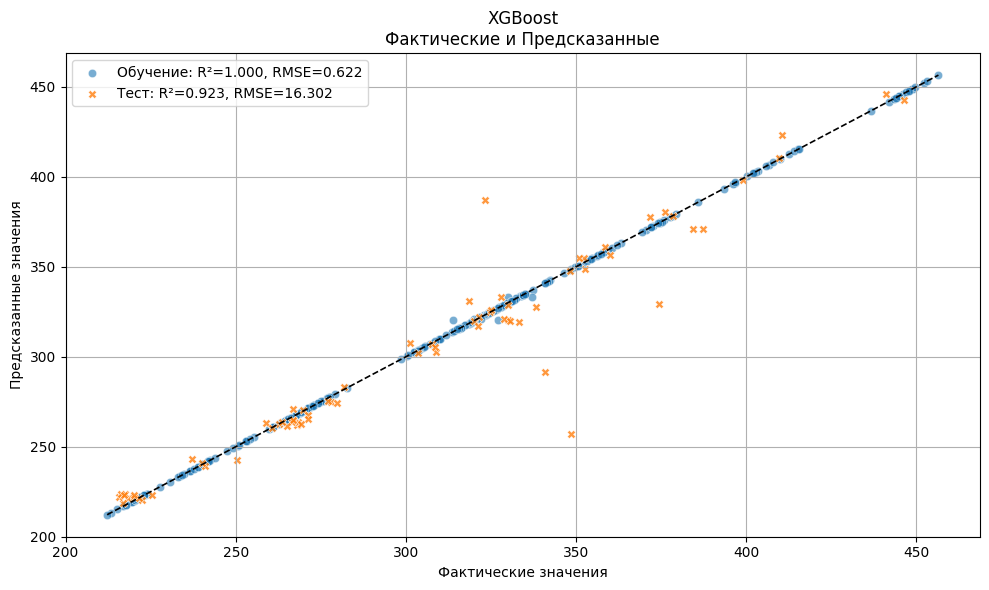

In [32]:
results["XGBoost"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(), "XGBoost"
)

In [33]:
# Параметры для подбора XGBoost
param_grid = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Continuous(0.01, 0.3),
    'subsample': Continuous(0.5, 1.0),
    'colsample_bytree': Continuous(0.5, 1.0),
    'gamma': Continuous(0, 5),
    'reg_alpha': Continuous(0, 2),
    'reg_lambda': Continuous(0, 2),
}

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Генетический поиск
evolved_search = GASearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='auto', random_state=0),
    cv=cv,
    scoring='r2',
    param_grid=param_grid,
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    error_score='raise'
)

# Обучение
evolved_search.fit(X_encoded_train, y_encoded_train)

# Лучшие параметры
print("Best parameters:", evolved_search.best_params_)
print("Best R2 score (CV):", evolved_search.best_score_)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	30    	0.89371	0.0382151  	0.942219   	0.805759   
1  	60    	0.92584	0.0117229  	0.945283   	0.892516   
2  	60    	0.934223	0.00817862 	0.946065   	0.914717   
3  	60    	0.941837	0.00389189 	0.946108   	0.930238   
4  	60    	0.945041	0.00188675 	0.950709   	0.94004    
5  	60    	0.946426	0.00197569 	0.950709   	0.940964   
6  	60    	0.947686	0.00187989 	0.951641   	0.945278   
7  	60    	0.948259	0.00452063 	0.951641   	0.931841   
8  	60    	0.95062 	0.00171218 	0.95654    	0.947644   
9  	60    	0.952664	0.00265777 	0.95654    	0.948773   
10 	60    	0.95466 	0.00265983 	0.959657   	0.950092   
11 	60    	0.955628	0.0022092  	0.959699   	0.951657   
12 	60    	0.957751	0.001309   	0.959699   	0.955869   
13 	60    	0.958839	0.000993278	0.959699   	0.95654    
14 	60    	0.959223	0.00131816 	0.96143    	0.953966   
15 	60    	0.960067	0.00101597 	0.961939   	0.958538   
16 	60    	0.960489	0.000907496	0.961939   	0.95839

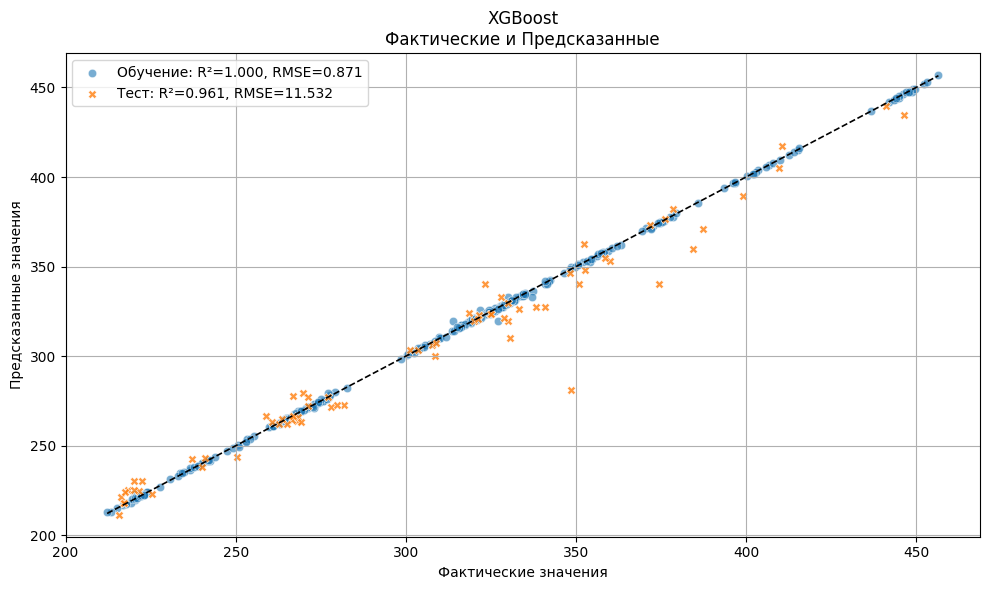

In [34]:
results["XGBoost"] = evaluate_holdout(
    X_encoded_train, X_encoded_test,
    y_encoded_train, y_encoded_test,
    XGBRegressor(**evolved_search.best_params_), "XGBoost"
)

Learning rate set to 0.033633
0:	learn: 59.1137584	total: 62.7ms	remaining: 1m 2s
1:	learn: 57.8870856	total: 147ms	remaining: 1m 13s
2:	learn: 56.5705001	total: 188ms	remaining: 1m 2s
3:	learn: 55.4038396	total: 214ms	remaining: 53.3s
4:	learn: 54.2097950	total: 253ms	remaining: 50.3s
5:	learn: 53.0274908	total: 272ms	remaining: 45.1s
6:	learn: 51.9309727	total: 308ms	remaining: 43.6s
7:	learn: 51.0175105	total: 338ms	remaining: 41.9s
8:	learn: 49.9134991	total: 374ms	remaining: 41.2s
9:	learn: 48.9183722	total: 411ms	remaining: 40.7s
10:	learn: 48.2073797	total: 450ms	remaining: 40.5s
11:	learn: 47.2923165	total: 487ms	remaining: 40.1s
12:	learn: 46.4089499	total: 519ms	remaining: 39.4s
13:	learn: 45.5165765	total: 556ms	remaining: 39.2s
14:	learn: 44.6614281	total: 592ms	remaining: 38.9s
15:	learn: 44.0142746	total: 630ms	remaining: 38.7s
16:	learn: 43.3755499	total: 669ms	remaining: 38.7s
17:	learn: 42.7505822	total: 711ms	remaining: 38.8s
18:	learn: 42.0466064	total: 751ms	remaini

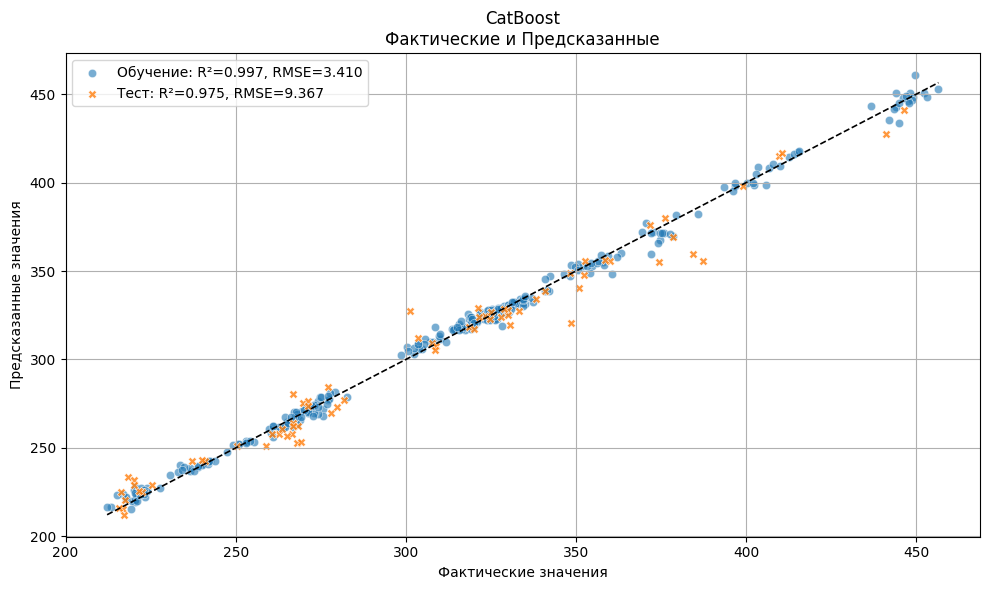

In [35]:
results["CatBoost"] = evaluate_holdout(
    X_catboost_train, X_catboost_test,
    y_catboost_train, y_catboost_test, 
    CatBoostRegressor(), "CatBoost",
    cat_features=catboost_features
)

In [36]:
# Достаём scale для обратного преобразования RMSE
df = pd.read_csv(f"{input_path}/scaled/full.csv")
column_name = "experiment.results.droplet_size.value"
column_index = df.columns.get_loc(column_name)

scaler = joblib.load(f"{input_path}/scaled/std_scaler.joblib")
scale = scaler.scale_[column_index]

for model in ['LinearRegression', 'SVR']:
    results[model]['rmse_train'] *= scale
    results[model]['rmse_test']  *= scale

In [37]:
results_df = pd.DataFrame(results)
results_df = results_df.T.reset_index().rename(columns={'index': 'Модель'})
results_df = results_df.sort_values("r2_test", ascending=False).reset_index(drop=True)
results_df = results_df.rename(columns={
    "model":      "Модель",
    "r2_train":   "R² обуч.",
    "rmse_train": "RMSE обуч.",
    "r2_test":    "R² тест.",
    "rmse_test":  "RMSE тест."
})

results_df

,Модель,R² обуч.,RMSE обуч.,R² тест.,RMSE тест.
0,SVR,0.989895,6.081541,0.986923,6.719734
1,CatBoost,0.996822,3.410447,0.974588,9.367232
2,RandomForest,0.993153,5.005821,0.966937,10.684714
3,XGBoost,0.999793,0.871348,0.961485,11.532071
4,GradientBoosting,0.991920,5.438013,0.930959,15.439994
5,LinearRegression,0.865076,22.222023,0.853068,22.524294
